In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs
from math import sqrt
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model, load_model

In [2]:
train = pd.read_csv('data/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train_images = train.loc[:,train.columns!='label']
train_labels = train.loc[:,train.columns=='label']
test_images = test.loc[:,test.columns!='label']
test_labels = test.loc[:,test.columns=='label']

In [5]:
train_images

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


In [6]:
train_labels = pd.Series(train_labels.values.reshape(-1))

In [7]:
test_labels = pd.Series(test_labels.values.reshape(-1))

<AxesSubplot:>

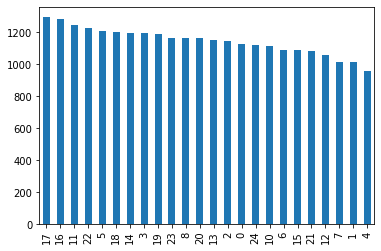

In [8]:
train_labels.value_counts().plot(kind='bar',)

In [9]:
def get_features(df,size):
    df = df[:size]
    df_img = df.loc[:].to_numpy(dtype='float64').reshape(-1,28,28,1)
    return df_img

In [10]:
def get_target(df,size):
    df = df[:size]
    vector = np.zeros(shape = (size,26),dtype='float64')
    for value,index in zip(df,df.index) :
        vector[index][value] = 1
    return vector

In [11]:
    def to_alphabet(number):
        return chr(number+65)

In [12]:
def plot_data(df,labels,size):
    df = df[:size]
    figs = df.loc[:].to_numpy(dtype='float64').reshape(-1,28,28,1)
    _,axs = plt.subplots(nrows=5,ncols=10,figsize=(25,25))
    for fig,label,ax in zip(figs,labels[:size],axs.flatten()):
        ax.axis('off')
        ax.imshow(fig,cmap='gray')
        ax.text(12,-5,to_alphabet(label),fontsize=20 )
    plt.show()

In [47]:
def prediction(model,image):
    image = image.reshape(1,28,28,1)
    return to_alphabet(np.argmax(model.predict(image)))

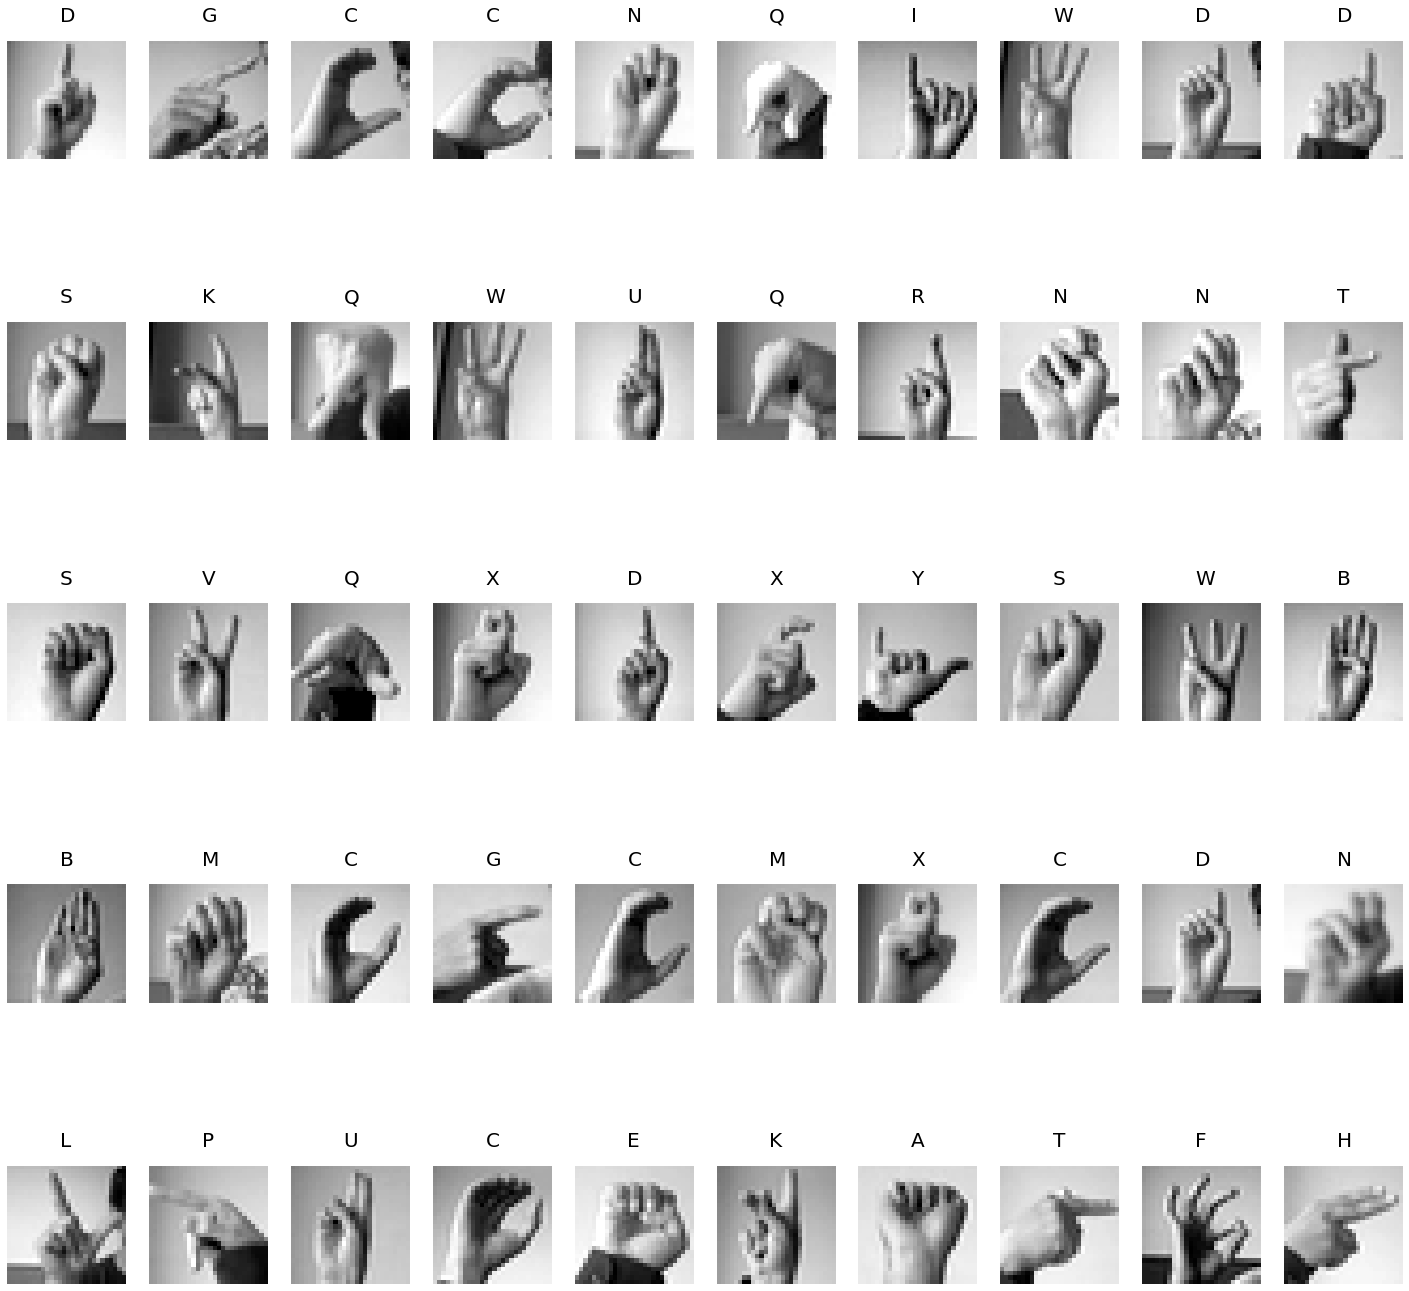

In [13]:
plot_data(train_images,train_labels,50)

In [14]:
X_train = get_features(train_images,len(train_images))

In [15]:
X_train.shape

(27455, 28, 28, 1)

In [16]:
y_train = get_target(train_labels,len(train_labels))

In [17]:
y_train.shape

(27455, 26)

In [18]:
X_test = get_features(test_images,len(test))

In [19]:
y_test = get_target(test_labels,len(test_labels))

In [20]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.05))]
    )

model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [22]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
858/858 [==============================] - 12s 11ms/step - loss: 3.2014 - accuracy: 0.5708 - val_loss: 0.6000 - val_accuracy: 0.8978
Epoch 2/20
858/858 [==============================] - 9s 10ms/step - loss: 0.2422 - accuracy: 0.9922 - val_loss: 0.3732 - val_accuracy: 0.9235
Epoch 3/20
858/858 [==============================] - 9s 10ms/step - loss: 0.1051 - accuracy: 0.9940 - val_loss: 0.3112 - val_accuracy: 0.9267
Epoch 4/20
858/858 [==============================] - 9s 10ms/step - loss: 0.0616 - accuracy: 0.9944 - val_loss: 0.3252 - val_accuracy: 0.9161
Epoch 5/20
858/858 [==============================] - 9s 10ms/step - loss: 0.0302 - accuracy: 0.9982 - val_loss: 0.4102 - val_accuracy: 0.9044
Epoch 6/20
858/858 [==============================] - 9s 10ms/step - loss: 0.0464 - accuracy: 0.9990 - val_loss: 0.3231 - val_accuracy: 0.9204
Epoch 7/20
858/858 [==============================] - 9s 10ms/step - loss: 0.0782 - accuracy: 0.9904 - val_loss: 0.2707 - val_accuracy: 0.936

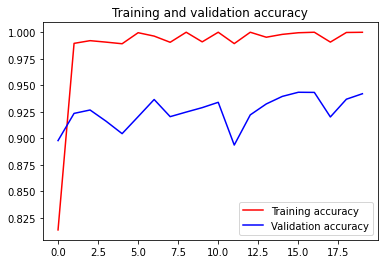

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [26]:
save_model(model,'sign_language.h5')

In [6]:
model = load_model('sign_language.h5')

In [7]:
tfjs.converters.save_keras_model(model,'models')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

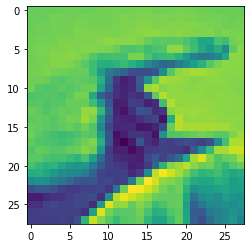

In [44]:
plt.imshow(X_test[0])

In [43]:
to_alphabet(np.argmax(model.predict(X_test[0].reshape(-1,28,28,1))))

'G'

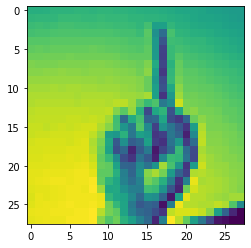

In [45]:
plt.imshow(X_test[1000])

In [49]:
prediction(model,X_test[1000])

'D'

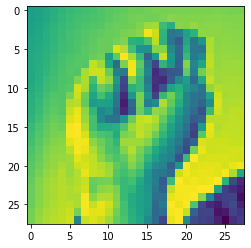

In [50]:
plt.imshow(X_test[2344])

In [52]:
prediction(model,X_test[2344])

'N'

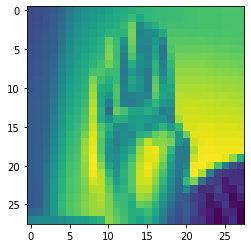

In [53]:
plt.imshow(X_test[2452])

In [54]:
prediction(model,X_test[2452])

'B'

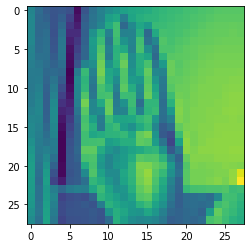

In [55]:
plt.imshow(X_test[5612])

In [57]:
prediction(model,X_test[5612])

'W'